# Searching Unstructured and Structured Data #
## Assignment 1: Retrieval models [100 points] ##
**TA**: Nikos Voskarides (n.voskarides@uva.nl)

In this assignment you will get familiar with basic information retrieval concepts. You will implement and evaluate different information retrieval ranking models and evaluate their performance.

We provide you with a Indri index. To query the index, you'll use a Python package ([pyndri](https://github.com/cvangysel/pyndri)) that allows easy access to the underlying document statistics.

For evaluation you'll use the [TREC Eval](https://github.com/usnistgov/trec_eval) utility, provided by the National Institute of Standards and Technology of the United States. TREC Eval is the de facto standard way to compute Information Retrieval measures and is frequently referenced in scientific papers.

This is a **groups-of-three assignment**, the deadline is **Monday, 22/1, at 23:59**. Code quality, informative comments and convincing analysis of the results will be considered when grading. Submission should be done through blackboard, questions can be asked on the course [Piazza](https://piazza.com/class/ixoz63p156g1ts).

### Technicalities (must-read!) ###

The assignment directory is organized as follows:
   * `./assignment.ipynb` (this file): the description of the assignment.
   * `./index/`: the index we prepared for you.
   * `./ap_88_90/`: directory with ground-truth and evaluation sets:
      * `qrel_test`: test query relevance collection (**test set**).
      * `qrel_validation`: validation query relevance collection (**validation set**).
      * `topics_title`: semicolon-separated file with query identifiers and terms.

You will need the following software packages (tested with Python 3.5 inside [Anaconda](https://conda.io/docs/user-guide/install/index.html)):
   * Python 3.5 and Jupyter
   * Indri + Pyndri (Follow the installation instructions [here](https://github.com/nickvosk/pyndri/blob/master/README.md))
   * gensim [link](https://radimrehurek.com/gensim/install.html)
   * TREC Eval [link](https://github.com/usnistgov/trec_eval)

### TREC Eval primer ###
The TREC Eval utility can be downloaded and compiled as follows:

    git clone https://github.com/usnistgov/trec_eval.git
    cd trec_eval
    make

TREC Eval computes evaluation scores given two files: ground-truth information regarding relevant documents, named *query relevance* or *qrel*, and a ranking of documents for a set of queries, referred to as a *run*. The *qrel* will be supplied by us and should not be changed. For every retrieval model (or combinations thereof) you will generate a run of the top-1000 documents for every query. The format of the *run* file is as follows:

    $query_identifier Q0 $document_identifier $rank_of_document_for_query $query_document_similarity $run_identifier
    
where
   * `$query_identifier` is the unique identifier corresponding to a query (usually this follows a sequential numbering).
   * `Q0` is a legacy field that you can ignore.
   * `$document_identifier` corresponds to the unique identifier of a document (e.g., APXXXXXXX where AP denotes the collection and the Xs correspond to a unique numerical identifier).
   * `$rank_of_document_for_query` denotes the rank of the document for the particular query. This field is ignored by TREC Eval and is only maintained for legacy support. The ranks are computed by TREC Eval itself using the `$query_document_similarity` field (see next). However, it remains good practice to correctly compute this field.
   * `$query_document_similarity` is a score indicating the similarity between query and document where a higher score denotes greater similarity.
   * `$run_identifier` is an identifier of the run. This field is for your own convenience and has no purpose beyond bookkeeping.
   
For example, say we have two queries: `Q1` and `Q2` and we rank three documents (`DOC1`, `DOC2`, `DOC3`). For query `Q1`, we find the following similarity scores `score(Q1, DOC1) = 1.0`, `score(Q1, DOC2) = 0.5`, `score(Q1, DOC3) = 0.75`; and for `Q2`: `score(Q2, DOC1) = -0.1`, `score(Q2, DOC2) = 1.25`, `score(Q1, DOC3) = 0.0`. We can generate run using the following snippet:

In [3]:
import logging
import sys
import os

def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    for subject_id, object_assesments in data.items():
        if not object_assesments:
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)

            continue

        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)
        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))
            
# The following writes the run to standard output.
# In your code, you should write the runs to local
# storage in order to pass them to trec_eval.
write_run(
    model_name='example',
    data={
        'Q1': ((1.0, 'DOC1'), (0.5, 'DOC2'), (0.75, 'DOC3')),
        'Q2': ((-0.1, 'DOC1'), (1.25, 'DOC2'), (0.0, 'DOC3')),
    },
    out_f=sys.stdout,
    max_objects_per_query=1000)

Q1 Q0 DOC1 1 1.0 example
Q1 Q0 DOC3 2 0.75 example
Q1 Q0 DOC2 3 0.5 example
Q2 Q0 DOC2 1 1.25 example
Q2 Q0 DOC3 2 0.0 example
Q2 Q0 DOC1 3 -0.1 example


Now, imagine that we know that `DOC1` is relevant and `DOC3` is non-relevant for `Q1`. In addition, for `Q2` we only know of the relevance of `DOC3`. The query relevance file looks like:

    Q1 0 DOC1 1
    Q1 0 DOC3 0
    Q2 0 DOC3 1
    
We store the run and qrel in files `example.run` and `example.qrel` respectively on disk. We can now use TREC Eval to compute evaluation measures. In this example, we're only interested in Mean Average Precision and we'll only show this below for brevity. However, TREC Eval outputs much more information such as NDCG, recall, precision, etc.

    $ trec_eval -m all_trec -q example.qrel example.run | grep -E "^map\s"
    > map                   	Q1	1.0000
    > map                   	Q2	0.5000
    > map                   	all	0.7500
    
Now that we've discussed the output format of rankings and how you can compute evaluation measures from these rankings, we'll now proceed with an overview of the indexing framework you'll use.

### Pyndri primer ###
For this assignment you will use [Pyndri](https://github.com/cvangysel/pyndri) [[1](https://arxiv.org/abs/1701.00749)], a python interface for [Indri](https://www.lemurproject.org/indri.php). We have indexed the document collection and you can query the index using Pyndri. We will start by giving you some examples of what Pyndri can do:

First we read the document collection index with Pyndri:

In [4]:
import pyndri

index = pyndri.Index('index/')

The loaded index can be used to access a collection of documents in an easy manner. We'll give you some examples to get some idea of what it can do, it is up to you to figure out how to use it for the remainder of the assignment.

First let's look at the number of documents, since Pyndri indexes the documents using incremental identifiers we can simply take the lowest index and the maximum document and consider the difference:

In [5]:
print("There are %d documents in this collection." % (index.maximum_document() - index.document_base()))

There are 164597 documents in this collection.


Let's take the first document out of the collection and take a look at it:

In [6]:
example_document = index.document(index.document_base())
print(example_document[0])

AP890425-0001


Here we see a document consists of two things, a string representing the external document identifier and an integer list representing the identifiers of words that make up the document. Pyndri uses integer representations for words or terms, thus a token_id is an integer that represents a word whereas the token is the actual text of the word/term. Every id has a unique token and vice versa with the exception of stop words: words so common that there are uninformative, all of these receive the zero id.

To see what some ids and their matching tokens we take a look at the dictionary of the index:

In [7]:
token2id, id2token, _ = index.get_dictionary()
print(list(id2token.items())[:15])

[(1, 'new'), (2, 'percent'), (3, 'two'), (4, '1'), (5, 'people'), (6, 'million'), (7, '000'), (8, 'government'), (9, 'president'), (10, 'years'), (11, 'state'), (12, '2'), (13, 'states'), (14, 'three'), (15, 'time')]


Using this dictionary we can see the tokens for the (non-stop) words in our example document:

In [8]:
print([id2token[word_id] for word_id in example_document[1] if word_id > 0])

['52', 'students', 'arrested', 'takeover', 'university', 'massachusetts', 'building', 'fifty', 'two', 'students', 'arrested', 'tuesday', 'evening', 'occupying', 'university', 'massachusetts', 'building', 'overnight', 'protest', 'defense', 'department', 'funded', 'research', 'new', 'york', 'city', 'thousands', 'city', 'college', 'students', 'got', 'unscheduled', 'holiday', 'demonstrators', 'occupied', 'campus', 'administration', 'building', 'protest', 'possible', 'tuition', 'increases', 'prompting', 'officials', 'suspend', 'classes', '60', 'police', 'riot', 'gear', 'arrived', 'university', 'massachusetts', '5', 'p', 'm', 'two', 'hours', 'later', 'bus', 'drove', 'away', '29', 'students', 'camped', 'memorial', 'hall', 'students', 'charged', 'trespassing', '23', 'students', 'arrested', 'lying', 'bus', 'prevent', 'leaving', 'police', '300', 'students', 'stood', 'building', 'chanting', 'looking', 'students', 'hall', 'arrested', '35', 'students', 'occupied', 'memorial', 'hall', '1', 'p', 'm',

The reverse can also be done, say we want to look for news about the "University of Massachusetts", the tokens of that query can be converted to ids using the reverse dictionary:

In [9]:
query_tokens = index.tokenize("University of Massachusetts")
print("Query by tokens:", query_tokens)
query_id_tokens = [token2id.get(query_token,0) for query_token in query_tokens]
print("Query by ids with stopwords:", query_id_tokens)
query_id_tokens = [word_id for word_id in query_id_tokens if word_id > 0]
print("Query by ids without stopwords:", query_id_tokens)

Query by tokens: ['university', '', 'massachusetts']
Query by ids with stopwords: [200, 0, 894]
Query by ids without stopwords: [200, 894]


Naturally we can now match the document and query in the id space, let's see how often a word from the query occurs in our example document:

In [10]:
matching_words = sum([True for word_id in example_document[1] if word_id in query_id_tokens])
print("Document %s has %d word matches with query: \"%s\"." % (example_document[0], matching_words, ' '.join(query_tokens)))
print("Document %s and query \"%s\" have a %.01f%% overlap." % (example_document[0], ' '.join(query_tokens),matching_words/float(len(example_document[1]))*100))

Document AP890425-0001 has 13 word matches with query: "university  massachusetts".
Document AP890425-0001 and query "university  massachusetts" have a 2.5% overlap.


While this is certainly not everything Pyndri can do, it should give you an idea of how to use it. Please take a look at the [examples](https://github.com/cvangysel/pyndri) as it will help you a lot with this assignment.

**CAUTION**: Avoid printing out the whole index in this Notebook as it will generate a lot of output and is likely to corrupt the Notebook.

### Parsing the query file
You can parse the query file (`ap_88_89/topics_title`) using the following snippet:

In [11]:
import collections
import io
import logging
import sys
import time 

def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)

            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                break

    return topics

with open('./ap_88_89/topics_title', 'r') as f_topics:
    print(parse_topics([f_topics]))

OrderedDict([('51', 'Airbus Subsidies'), ('52', 'South African Sanctions'), ('53', 'Leveraged Buyouts'), ('54', 'Satellite Launch Contracts'), ('55', 'Insider Trading'), ('56', 'Prime (Lending) Rate Moves, Predictions'), ('57', 'MCI'), ('58', 'Rail Strikes'), ('59', 'Weather Related Fatalities'), ('60', 'Merit-Pay vs. Seniority'), ('61', 'Israeli Role in Iran-Contra Affair'), ('62', "Military Coups D'etat"), ('63', 'Machine Translation'), ('64', 'Hostage-Taking'), ('65', 'Information Retrieval Systems'), ('66', 'Natural Language Processing'), ('67', 'Politically Motivated Civil Disturbances'), ('68', 'Health Hazards from Fine-Diameter Fibers'), ('69', 'Attempts to Revive the SALT II Treaty'), ('70', 'Surrogate Motherhood'), ('71', 'Border Incursions'), ('72', 'Demographic Shifts in the U.S.'), ('73', 'Demographic Shifts across National Boundaries'), ('74', 'Conflicting Policy'), ('75', 'Automation'), ('76', 'U.S. Constitution - Original Intent'), ('77', 'Poaching'), ('78', 'Greenpeace'

### Task 1: Implement and compare lexical IR methods [35 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html) and 
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - [Positional Language Models](http://sifaka.cs.uiuc.edu/~ylv2/pub/sigir09-plm.pdf) define a language model for each position of a document, and score a document based on the scores of its PLMs. The PLM is estimated based on propagated counts of words within a document through a proximity-based density function, which both captures proximity heuristics and achieves an effect of “soft” passage retrieval. Implement the PLM, all five kernels, but only the Best position strategy to score documents. Use 𝛔 equal to 50, and Dirichlet smoothing with 𝛍 optimized on the validation set (decide how to optimize this value yourself and motivate your decision in the report). **[10 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[5 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences. This is *very important* in order to understand who the different retrieval functions behave.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

**IMPORTANT**: You should structure your code around the helper functions we provide below.

In [12]:
import numpy as np

with open('./ap_88_89/topics_title', 'r') as f_topics:
    queries = parse_topics([f_topics])

index = pyndri.Index('index/')

num_documents = index.maximum_document() - index.document_base()

dictionary = pyndri.extract_dictionary(index)

tokenized_queries = {
    query_id: [dictionary.translate_token(token)
               for token in index.tokenize(query_string)
               if dictionary.has_token(token)]
    for query_id, query_string in queries.items()}

query_term_ids = set(
    query_term_id
    for query_term_ids in tokenized_queries.values()
    for query_term_id in query_term_ids)

print('Gathering statistics about', len(query_term_ids), 'terms.')

# inverted index creation

total_terms = 0

document_lengths = {}
unique_terms_per_document = {}

start_time = time.time()

inverted_index = collections.defaultdict(dict)
collection_frequencies = collections.defaultdict(int)

# extended inverted index creation with position of terms in document
positional_inverted_index = collections.defaultdict(dict)

# extended inverted index creation with position of terms in document
positions_of_term_in_document = collections.defaultdict(dict)

# Set containing the vocabulary of the words used in the queries
query_vocabulary = set()
# Set containing the vocabulary from all documents
full_vocabulary = set()

for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)

#   collecting the frequeuncy of the words (that appear in some query)
#   and general statistics about the document
    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    document_length = sum(document_bow.values())
    
#     dictionary with list of positions for this document
    positions_dictionary = collections.defaultdict(int)
#         ADDED !!! for positional inverted index
    for position, token_id in enumerate(doc_token_ids):
#         updating the full vocabulary
        full_vocabulary.add(token_id)
        
#         if we are interested for that word (has been found in a query)
        if token_id in query_term_ids :
        
#         updating the query vocabulary
            query_vocabulary.add(token_id)
        
#             initialization of list of positions, for this document, and for this term
            if token_id not in positions_dictionary:
                positions_dictionary[token_id] = []
#             including current position for positions of this term in this document
            positions_dictionary[token_id].append(position)
    
#     for every word that we are interested, that was found in this document
    for token_id in positions_dictionary.keys():
#         we update the positional inverted index
        positional_inverted_index[token_id][int_doc_id] = positions_dictionary[token_id]
        # print('doc:',int_doc_id ,' positions:', positions_dictionary[token_id],' documents :', positional_inverted_index[token_id])

#         list of positions of query terms in a document
        # positions_of_term_in_document[int_doc_id][token_id] = positions_dictionary[token_id]
        

    document_lengths[int_doc_id] = document_length
    total_terms += document_length

    unique_terms_per_document[int_doc_id] = len(document_bow)

    for query_term_id in query_term_ids:
        assert query_term_id is not None

        document_term_frequency = document_bow.get(query_term_id, 0)

        if document_term_frequency == 0:
            continue

        collection_frequencies[query_term_id] += document_term_frequency
        inverted_index[query_term_id][int_doc_id] = document_term_frequency

avg_doc_length = total_terms / num_documents

print('Inverted index creation took', time.time() - start_time, 'seconds.')

Gathering statistics about 456 terms.
Inverted index creation took 63.8591685295105 seconds.


## Helper functions

In [7]:
#Trec evaluatation
import subprocess
import matplotlib.pyplot as plt
def trec_eval(validation_file,test_file_name):
    """
   returs the evaluation for a given file against a reference file
   returns eval for each single query document pair as well as the 
   overall scores
   
    """
    cmd = ['./run_trec_eval.sh',validation_file, test_file_name]
    evaluation = {}
    process = subprocess.Popen(cmd, stdout=subprocess.PIPE)
    for line in process.stdout:
        splits = line.decode().strip().split()
        doc_id, query_id, score = splits
        if splits[1] in evaluation:
            evaluation[query_id].append({doc_id: float(score)})
        else:
            evaluation[query_id] = [{doc_id:float(score)}]
            
        process.wait()
        
    return evaluation

validation_data = 'ap_88_89/qrel_validation'
test_data = 'ap_88_89/qrel_test'

measure_names = ['ndcg_cut_10', 'map_cut_1000', 'P_5', 'recall_1000']

In [10]:
# put scores in the right array structure
def restruct(arr, overall=True):
    ndcg10 = []
    map1000 = []
    p5 = []
    r1000 = []
    if overall:
        query_scores = arr['all']
        return [query_scores[2][measure_names[0]], query_scores[3][measure_names[1]],query_scores[0][measure_names[2]],query_scores[1][measure_names[3]]]
            
    for query_id, query_scores in arr.items():
        if overall is False and query_id is not 'all':
            p5.append(query_scores[0][measure_names[2]])
            r1000.append(query_scores[1][measure_names[3]])
            ndcg10.append(query_scores[2][measure_names[0]])
            map1000.append(query_scores[3][measure_names[1]])
    return ndcg10, map1000, p5, r1000

In [15]:
# calculates kl divergence 
def kl_divergence(query_language_model, document_language_model ):
    """
    calculate kl-divergence 
    given a language model and a document model
    
    """
    return query_language_model * np.log( query_language_model / document_language_model)
def calculate_query_lm(document_term_positions,param):
    
    """
    calculates the smoothed query language model
    return: log p(q|d): score for document generating the query
    """
    
     # calculating query language model (unigram)
    query_language_model = {}
    for query_term,positions in document_term_positions.items():
        freq = len(positions)
        if query_term not in query_language_model:
            query_language_model[query_term] = 0
        # add prob for query_term to dict    
        query_language_model[query_term] += 1/freq
    # calculate background probability
    smoothed_query_language_model = {}
    for query_term, freq in query_language_model.items():
        # background word count
        C = collection_frequencies[query_term]
        if query_term not in query_language_model:
            smoothed_query_language_model[query_term] = 0
        # add background probability to dict    
        smoothed_query_language_model[query_term] = C/total_terms  
    # calculate log(q|d), formula see above
    score = 0
    for query_term,_ in document_term_freq.items():
        score += np.log(query_language_model[query_term]/(param*smoothed_query_language_model[query_term])) +len(document_term_freq) * np.log(param)     
    return score

In [46]:
# plot for parameter validation
def plot_validation(score, params):
    # transpose array
    plt.plot(params,score, label=measure_names[0])
    plt.xlabel('k')
    plt.ylabel('NDCG')
    #plt.legend(measure_names,loc=(1.04,0))  
    plt.show()

In [44]:
# find best parameter by finding the best ndcg score

def find_best_param(all_scores, params):
    return params[np.argmax(np.array(all_scores))]
    

In [18]:
# for every query get id of documents that contain at least one query token
doc_list = {}
#iterate through queries
for query_id, query_tokens in tokenized_queries.items():
    accumulate_docs = set()
    #iterate through query tokens
    for query_token in query_tokens:
        # iterate through doc ids that contain at least one word of the query token 
        for docs in inverted_index[query_token].keys():
            # append doc id 
            accumulate_docs.add(docs)
    doc_list[str(query_id)] = accumulate_docs

In [19]:
# calculate the average lenght of documents
av_document_length = np.mean(list(document_lengths.values()))
print('Average document length: ',av_document_length)

def run_retrieval(model_name, score_fn, param=None):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    """
    run_out_path = '{}.run'.format(model_name)

    if os.path.exists(run_out_path):
        #run_out_path+'_copy'
        return
    retrieval_start_time = time.time()

    print('Retrieving using', model_name)

    data = {}

    # TODO: fill the data dictionary. 
    # The dictionary data should have the form: query_id --> (document_score, external_doc_id)

    # Iterates through queries
    for query in queries.items():
        query_id, _ = query
        print (query_id)
        query_term_ids = tokenized_queries[query_id]
        scores = []
        # Iterate through every token 
        #for document_id in range(index.document_base(), index.maximum_document()):  
        for document_id in doc_list[str(query_id)]: 
            ex_doc_id, _ = index.document(document_id)

            # calculate the score for every document-query pair
            score = score_fn(document_id, query_id, positional_inverted_index, param)

            # Append score for a specific document 
            scores.append((score, ex_doc_id))
        # Append scores for a query
        data[str(query_id)] = scores
    print('Retrieval took:', time.time() - retrieval_start_time )
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)

Average document length:  256.438197537


## TF-IDF

We discard the multiplication term that is added for very long queries in our implementation, since there is no value given for k3

In [20]:
def tfidf(int_document_id, query_id, positional_inverted_index , _ ):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_id: the query id of the query
    :param positional_inverted_index: an extended inverted index that also stores the position of the 
                                            terms on the document
    """
    
#     the final score
    score = 0
#     for every word in the query
    for query_token_id in tokenized_queries[query_id]:
#         if the query term has been found on the document
        if int_document_id in positional_inverted_index[query_token_id]:
#         calculating tf
            tf = 1 + np.log(   len( positional_inverted_index    [query_token_id][int_document_id]   )  )
#         calculating idf
            idf  = np.log(num_documents/len(inverted_index[query_token_id]))
#        calculating score for this term
            score += tf*idf
    return score

run_retrieval('tfidf', tfidf)

In [73]:
# Evaluation 
tfidf_scores = trec_eval(test_data, 'tfidf.run')
print(len(tfidf_scores))
print('Scores:', dict(zip(measure_names, restruct(tfidf_scores))))
tfidf_scores = restruct(tfidf_scores, False)

# Scores: {'ndcg_cut_10': 0.4254, 'map_cut_1000': 0.22, 'P_5': 0.435, 'recall_1000': 0.6491}

# Scores: {'ndcg_cut_10': 0.4169, 'map_cut_1000': 0.2155, 'P_5': 0.4317, 'recall_1000': 0.651}


121
Scores: {'ndcg_cut_10': 0.4254, 'map_cut_1000': 0.22, 'P_5': 0.435, 'recall_1000': 0.6491}


## BM25

We discard the multiplication term that is added for very long queries in our implementation, since there is no value given for k3

In [21]:
def BM25(int_document_id, query_id, positional_inverted_index, _ , k1=1.2, b=0.75):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_id: the query id of the query
#     :param positional_inverted_index: an extended inverted index that also stores the position of the 
#                                             terms on the document
    """
    score = 0
    # Iterate through query terms 
    for query_token_id in tokenized_queries[query_id]:
#         if the query term has been found on the document
        if int_document_id in positional_inverted_index[query_token_id]:
            # getting number of times this term appeared in this document
            count = len( positional_inverted_index    [query_token_id][int_document_id]   )
            # getting document length
            len_doc = document_lengths[int_document_id]

            tf = (((k1 + 1) * count) / ((k1 * ((1-b) + b * (len_doc/av_document_length))) + count)) 
            idf = np.log(num_documents/len(positional_inverted_index[query_token_id]))
            score += tf*idf
    return score

# run_retrieval('BM25', BM25)

In [20]:
# Evaluation 
bm25_scores = trec_eval(test_data, 'BM25.run')
print('Scores:', dict(zip(measure_names, restruct(bm25_scores))))
bm25_scores = restruct(bm25_scores, False)

Scores: {'ndcg_cut_10': 0.4086, 'map_cut_1000': 0.2173, 'P_5': 0.4133, 'recall_1000': 0.6524}


# Language models

## Jelinek-Mercer 

Explore different values of 𝛌 in the range [0.1, 0.5, 0.9]

In [22]:
def JM(int_document_id, query_id, positional_inverted_index, lamb):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_id: the query id of the query
    :param positional_inverted_index: an extended inverted index that also stores the position of the 
# #                                             terms on the document
    """
    
    score = 0
    # Iterate through query terms 
    for query_token_id in tokenized_queries[query_id]:
#         if the query term has been found on the document
        if int_document_id in positional_inverted_index[query_token_id]:
#         calculating the document term model p(w|d)
            document_term_model =  len(positional_inverted_index [query_token_id][int_document_id]) /document_lengths[int_document_id]
        else:
            document_term_model = 0
#         calculating the corpus term model  p(w|C)
        corpus_term_model = collection_frequencies[query_token_id] / total_terms
        prob = lamb* document_term_model  + (1.-lamb)* corpus_term_model
        score += np.log(prob)
    return score

lambdas = [0.1,0.5,0.9]

# for lamb in lambdas:
#     run_retrieval('JM_'+str(lamb), JM, lamb) 

[0.3676]


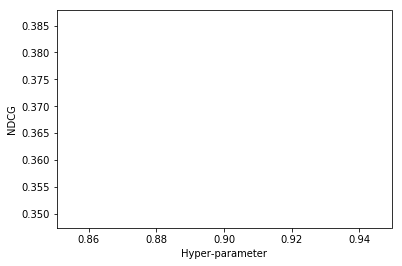

Best hyper param 0.9
Scores: {'ndcg_cut_10': 0.3744, 'map_cut_1000': 0.1929, 'P_5': 0.3733, 'recall_1000': 0.6212}


In [135]:
# run evaluation for different lambdas on validation data
# change array stracture in a suitabale way for us
JM_val_scores = [restruct(trec_eval(validation_data, 'JM_'+str(lamb)+'.run'))[0] for lamb in lambdas]
print(JM_val_scores)
# plot overall scores for all measures
plot_validation(JM_val_scores, lambdas)
# get best parameter by NDCG
best_param_JM = find_best_param(JM_val_scores,lambdas )
print('Best hyper param', best_param_JM)
# run evaluation for different lambdas on test data
JM_scores = trec_eval(test_data, 'JM_'+str(best_param_JM)+'.run')
print('Scores:', dict(zip(measure_names, restruct(JM_scores))))
JM_scores = restruct(JM_scores, False)

## Dirichlet Prior 

Explore different values of 𝛍 [500, 1000, 1500]

In [23]:
def DP(int_document_id, query_id, positional_inverted_index, mu):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_id: the query id of the query
    :param positional_inverted_index: an extended inverted index that also stores the position of the 
# #                                             terms on the document
    """
    
    score = 0
    len_doc = document_lengths[int_document_id]
    
#     some documents do not contain any words, so their score is obviously 0
    if len_doc == 0:
        return - float('inf')
    
    # Iterate through query terms 
    for query_token_id in tokenized_queries[query_id]:
#         if the query term has been found on the document
        if int_document_id in positional_inverted_index[query_token_id]:
#         calculating the document term model p(w|d)
            document_term_model =  len(positional_inverted_index [query_token_id][int_document_id]) / len_doc
        else:
            document_term_model = 0
#         calculating the corpus term model  p(w|C)
        corpus_term_model = collection_frequencies[query_token_id] / total_terms
    
        prob = ((len_doc/(len_doc + mu)) * document_term_model) + (mu/(mu+ len_doc)) * corpus_term_model
        score += np.log(prob)
    return score

# mus = [500,1000,1500]

# for mu in mus:
#     run_retrieval('DP_'+str(mu), DP, mu) 

[0.4026]


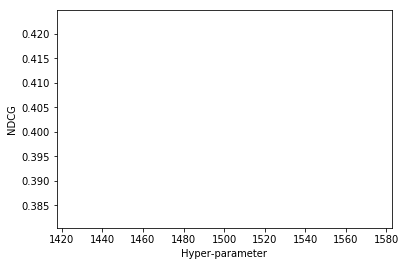

Best hyper param 1500
Scores: {'ndcg_cut_10': 0.4111, 'map_cut_1000': 0.2139, 'P_5': 0.405, 'recall_1000': 0.6367}


In [142]:
# run evaluation for different lambdas on validation data
# change array stracture in a suitabale way for us
DP_val_scores = [restruct(trec_eval(validation_data, 'DP_'+str(mu)+'.run'))[0] for mu in mus]
print(DP_val_scores)
# plot overall scores for all measures
plot_validation(DP_val_scores, mus)
# get best parameter by NDCG
best_param_DP = find_best_param(DP_val_scores,mus)
print('Best hyper param', best_param_DP)
# run evaluation for different lambdas on test data
DP_scores = trec_eval(test_data, 'DP_'+str(best_param_DP)+'.run')
print('Scores:', dict(zip(measure_names, restruct(DP_scores))))
DP_scores = restruct(DP_scores, False)

## Absolute discount smoothing

Explore different values of 𝛅 in the range [0.1, 0.5, 0.9]

In [24]:
def ADS(int_document_id, query_id, positional_inverted_index, delta=0.1):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_id: the query id of the query
    :param positional_inverted_index: an extended inverted index that also stores the position of the 
# #                                             terms on the document
    """
    
    score = 0
    len_doc = document_lengths[int_document_id]
    
#     some documents do not contain any words, so their score is obviously 0
    if len_doc == 0:
        return - float('inf')
    
    # Iterate through query terms 
    for query_token_id in tokenized_queries[query_id]:
#         if the query term has been found on the document
        if int_document_id in positional_inverted_index[query_token_id]:
#         calculating the document term model p(w|d)
            document_term_model = len(positional_inverted_index [query_token_id][int_document_id])/len_doc
        else:
            document_term_model = 0
        
        C = collection_frequencies[query_token_id]
        
        prob = document_term_model + (delta* unique_terms_per_document[int_document_id]/len_doc) * (C/total_terms)
        score += np.log(prob)
    return score

# deltas = [0.1,0.5, 0.9]
# for delta in deltas:
#     run_retrieval('ADS_'+str(delta), ADS, delta) 

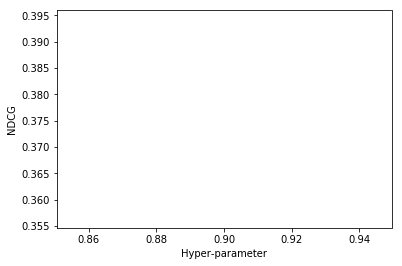

Best hyper param 0.9
Scores: {'ndcg_cut_10': 0.3821, 'map_cut_1000': 0.1949, 'P_5': 0.37, 'recall_1000': 0.62}


In [430]:
# run evaluation for different lambdas on validation data
# change array stracture in a suitabale way for us
ADS_val_scores = [restruct(trec_eval(validation_data, 'ADS_'+str(delta)+'.run'))[0] for delta in deltas]
# plot overall scores for all measures
plot_validation(ADS_val_scores, deltas)
# get best parameter by NDCG
best_param_ADS = find_best_param(ADS_val_scores,deltas )
print('Best hyper param', best_param_ADS)
# run evaluation for different lambdas on test data
ADS_scores = trec_eval(test_data, 'ADS_'+str(best_param_ADS)+'.run')
print('Scores:', dict(zip(measure_names, restruct(ADS_scores))))
ADS_scores = restruct(ADS_scores, False)

## Position Language Models

In [ ]:
    # Implementing results of kernels depending on distance for means of reduced complexity
def gaussian_kernel(sigma=50):
    k = np.zeros(sigma+1)
    for i in range(sigma+1):
        k[i] = np.exp( (- (i)**2) / (2*sigma**2))
    return k

def triangle_kernel(sigma=50):
    k = np.zeros(sigma+1)
    for i in range(sigma+1):
        k[i] = 1 - (i/sigma)
    return k

def cosine_kernel(sigma=50):
    k = np.zeros(sigma+1)
    for i in range(sigma+1):
        k[i] = 1/2 *(1 + np.cos(i*np.pi/sigma))
    return k

def circle_kernel(sigma=50):
    k = np.zeros(sigma+1)
    for i in range(sigma+1):
        k[i] = np.sqrt(1 - (i/sigma)**2)  
    return k

def passage_kernel(sigma=50):
    k = np.ones(sigma+1)
    return k

In [ ]:

def PLM(int_document_id, query_id, positional_inverted_index, params):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_id: the query id of the query
    :param positional_inverted_index: an extended inverted index that also stores the position of the 
# #                                             terms on the document
    """
    
#     variance for kernel functions
    sigma = 50
    
    mu = params // 1
    
    print('mu:',mu,', sigma:',sigma)
    
    kernel_pointer  = params % 1
    
    if kernel_pointer == 0 :
        kernel = gaussian_kernel
    elif kernel_pointer == 1 :
        kernel = triangle_kernel
    elif kernel_pointer == 2 :
        kernel = cosine_kernel
    elif kernel_pointer == 3 :
        kernel = circle_kernel
    else:
        kernel = passage_kernel
    # array with precalculated kernel values, where the index is equal to the distance |i - j|
    k = kernel(sigma)
    
    # storing the tokens of the query because we will need them many times
    tokenized_query = tokenized_queries[query_id]

#     calculate the maximum position where a query term appears in the document,
#     There is no reason to calculate position scores after this value because Best Position Strategy will be used
    max_position = 0
    # for every query term
    for query_token_id in tokenized_query:
        # for every appearance of this term in this document
        for positions in positional_inverted_index[query_token_id][int_document_id]:
            temp_max = max(positions)
            if temp_max > max_position :
                max_position = temp_max
        
#     There are cases where the only match with the document is on the first word ( position 0 )
    max_position += 1
            
#     Considering that the PLM-Based Document Ranking will be implemented using Best Position Strategy , 
#     The best position will be lower or equal to the max position where a term of the query was found in the document
    
    virtual_document = {}
    score = 0
    # len_doc = document_lengths[int_document_id]
    # Iterate through query terms 
    for query_token_id in tokenized_query:
        
#       initialize the virtual document with zero appearances of this word
#       sum up to the total propagated count of term word_id at position i
#       virtual_document is the :  c'(w,i)
        virtual_document[query_token_id] = np.zeros(max_position)
        
#         if the query term has been found on the document
        if int_document_id in positional_inverted_index[query_token_id]:

    #         for every term appearance in the document
            for j in positional_inverted_index[query_token_id][int_document_id]:
    #         left side :
    #           if all 50 values of the kernel will be used
                limit = sigma +1
    #           if less than 50 values of the kernel will be used
                if j < sigma:
                    limit = j+1
                for i in range(limit):
                        virtual_document[query_token_id][j-i] += k[i]

    #         right side :
    #           if all 50 values of the kernel will be used
                limit = sigma +1
    #           ( again we do not care for score values, for positions greater than max_position,
    #             because Best Position Strategy will be used for final scoring of document)
    #           if less than 50 values of the kernel will be used
                if max_position - j  <= sigma :
                    limit = max_position - j
                    # here the range will be starting from value 1 so that in position j the kernel will not be added twice
                for i in range(1,limit):
                        virtual_document[query_token_id][j+i] += k[i]
                    

#     calculating the length of the virtual document at all positions
    Z = np.zeros(max_position)
#     for every word included in the query, add all propagated counts, position wise
    for query_token_id in tokenized_query:
        Z += virtual_document[query_token_id]

    
#     calculating normalized language model per word
#     p_mu (w|D) (Words contributing equally)
    normalized_document_language_model = {}
    for query_token_id in tokenized_query:
        C = collection_frequencies[query_token_id]
        
        normalized_document_language_model[query_token_id] = (virtual_document[query_token_id] + mu*(C/total_terms))/ (Z + mu)
        
#   p(w|Q)
    query_language_model = {}
#     calculating as unigram model
    for query_token_id in tokenized_query:
#         initializing value
        if query_token_id not in query_language_model:
            query_language_model[query_token_id] = 0
#         adding value to unigram model
        query_language_model[query_token_id] += 1/len(tokenized_query)
        
    scores = np.zeros(max_position)
#     calculating final score for all positions
    for query_token_id in tokenized_query:
        scores += query_language_model[query_token_id] *np.log(query_language_model[query_token_id] / normalized_document_language_model[query_token_id])
    scores = - scores
        
        
#     print('query id:',query_term_id, ', doc_id:',int_document_id,scores.shape, document_term_positions)
#    returning only the maximum score because Best Position Strategy is being used
    return np.max(scores)

run_retrieval('PLM', PLM, 500.0)

In [ ]:
# run evaluation for different lambdas on validation data
# change array stracture in a suitabale way for us
PLM_val_scores = collection.defaultdict(list)
mus = []
for mu in mus:
    for kernel_choises in kernel_pointers:
#         get a list of scores for the 4 measures  'measure_names'
        score = restruct(trec_eval(validation_data, 'PLM_doc_wise_'+ kernel_names[kernel_choises] + '_' + str(mu))
#         choose one score
        assert('Done' = True) 'choose a score!'
                         
        PLM_val_scores[str(kernel_names[kernel_choises])].append((mu, score))
        
                         
#  find max for mu
#best_param = 
# plot         


print('Best hyper param', best_param)
# run evaluation for different lambdas on test data
PLM_scores = trec_eval(test_data, 'PLM_'+'_'+str(best_param)+'.run')
print('Scores:', dict(zip(measure_names, restruct(PLM_scores))))
PLM_scores = restruct(PLM_scores, False)

## Statistic Significance Testing

In [36]:
from scipy import stats

def compute_ttest(scoresA, scoresB):
    # use sediac 
    alpha = 0.05
    comparisons = 4
    alpha = 1 - (1 - alpha)**(1./4.)
    for i in range(comparisons):
        _, p = stats.ttest_rel(scoresA[i],scoresB[i])
        if p < alpha:
            print('H0 rejected for', measure_names[i])
        else:
            print('H0 accepted for', measure_names[i])

In [ ]:
# compare TF-IDF with BM25:
print('Compare TF-IDF with BM25')
compute_ttest(tfidf_scores, bm25_scores)
print('Compare TF-IDF with best Jelinek-Mercer')
compute_ttest(tfidf_scores, JM_scores)
print('Compare TF-IDF with best Dirichlet Prior')
compute_ttest(tfidf_scores, DP_scores)
print('Compare TF-IDF with best ADS')
compute_ttest(tfidf_scores, ADS_scores)
print('Compare TF-IDF with best PLM')
compute_ttest(tfidf_scores, PLM_scores)

### Task 2: Latent Semantic Models (LSMs) [20 points] ###

In this task you will experiment with applying distributional semantics methods ([LSI](http://lsa3.colorado.edu/papers/JASIS.lsi.90.pdf) **[5 points]** and [LDA](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf) **[5 points]**) for retrieval.

You do not need to implement LSI or LDA on your own. Instead, you can use [gensim](http://radimrehurek.com/gensim/index.html). An example on how to integrate Pyndri with Gensim for word2vec can be found [here](https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py). For the remaining latent vector space models, you will need to implement connector classes (such as `IndriSentences`) by yourself.

In order to use a latent semantic model for retrieval, you need to:
   * build a representation of the query **q**,
   * build a representation of the document **d**,
   * calculate the similarity between **q** and **d** (e.g., cosine similarity, KL-divergence).
     
The exact implementation here depends on the latent semantic model you are using. 
   
Each of these LSMs come with various hyperparameters to tune. Make a choice on the parameters, and explicitly mention the reasons that led you to these decisions. You can use the validation set to optimize hyper parameters you see fit; motivate your decisions. In addition, mention clearly how the query/document representations were constructed for each LSM and explain your choices.

In this experiment, you will first obtain an initial top-1000 ranking for each query using TF-IDF in **Task 1**, and then re-rank the documents using the LSMs. Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

Perform significance testing **[5 points]** (similar as in Task 1) in the class of semantic matching methods.

Perform analysis **[5 points]**

In [25]:
#Query-Document parser

def query_doc_parser(file_name):
    F = open(file_name,"r")
    query_doc_dictionary={}
    for row in F:
        if len(row.strip()) == 0:
            continue
        row=row.split()
        _, doc_id = index.document_ids([row[2]])[0]
        if row[0] not in query_doc_dictionary.keys():
            query_doc_dictionary[row[0]] = [doc_id]
        else :
            l=query_doc_dictionary[row[0]]
            l.append(doc_id)
            query_doc_dictionary[row[0]] = l
    return query_doc_dictionary

In [21]:
from gensim import corpora
from gensim.models import tfidfmodel
from gensim.models import lsimodel 
from gensim.models import ldamodel 
import pyndri.compat
from gensim.similarities import Similarity
import os.path

class PCorpus(object):
    def __init__(self, index):
        self.index = index
        dictionary = pyndri.extract_dictionary(index)
        docs = pyndri.compat.IndriSentences(index, dictionary)
        self.dictionary = corpora.Dictionary(docs)
        #TODO
        self.dictionary.filter_extremes(no_below=5)
    
    def save(self, file):
        self.dictionary.save(file)
        
    def __iter__(self):
        dictionary = pyndri.extract_dictionary(index)
        docs = pyndri.compat.IndriSentences(index, dictionary)
        for doc in docs:
            yield self.dictionary.doc2bow(doc)

In [23]:
# save corpus to file after serialization
similarity_index_base = 'simlarity_index'
similarity_index_filename = 'similarity_index.index'


similarity_index_base_lda = 'simlarity_index_lda'
similarity_index_filename_lda = 'similarity_index_lda.index'

# TODO: in this special case we know that we have 150 topics
corpus_filename = 'corpus.mm'
dict_filename = 'corpus.dict'
num_topics_LSI = 64
num_topics_LDA = 64


if not os.path.isfile(corpus_filename):
    corpus = PCorpus(index)
    corpora.MmCorpus.serialize(corpus_filename, corpus)
    corpus.save(dict_filename)
# load corpus https://radimrehurek.com/gensim/tut2.html
if os.path.isfile(corpus_filename):
    dictionary = corpora.Dictionary.load(dict_filename)
    corpus = corpora.MmCorpus(corpus_filename)
    # initialise lsi model
    lsi = lsimodel.LsiModel(corpus,id2word = dictionary, num_topics = num_topics_LSI)
    lda = ldamodel.LdaModel(corpus,id2word = dictionary, num_topics = num_topics_LDA)
    # transform corpus to LDA space and index it
    lsi_corpus = lsi[corpus]
    # transform corpus to LSI space and index it
    lda_corpus = lda[corpus]

    
# index corpus for lsi similarity https://radimrehurek.com/gensim/tut3.html
if not os.path.isfile(similarity_index_filename):
    # transform corpus to LSI space and index it
    similarity_index = Similarity(similarity_index_base, lsi_corpus,  num_topics_LSI)
    similarity_index.save(similarity_index_filename)
else:
    similarity_index = Similarity.load(similarity_index_filename)

    
# index corpus for lda    
if not os.path.isfile(similarity_index_filename_lda):
    # generated similariy index
    lda_similarity_index = Similarity(similarity_index_base_lda, lda_corpus,  num_topics_LDA)
    # save simlarity indexed
    lda_similarity_index.save(similarity_index_filename_lda)
else:
    lda_similarity_index = Similarity.load(similarity_index_filename_lda)



## LSI

In [24]:
# parse tf-idf best 1000 docs per query
ranked_queries = query_doc_parser("tfidf.run")


# iterate through queries
scores = collections.defaultdict(list)
similarity_index.num_best = None
start_time = time.time()
for query_id, docs in ranked_queries.items():
    # bow for query terms
    vec_bow = dictionary.doc2bow((queries[query_id]).lower().split())
    # convert the query to LSI space
    vec_lsi = lsi[vec_bow] 
    # get similarity for all documents
    sims = similarity_index[vec_lsi]
    sims = sorted(enumerate(sims), key=lambda item: -item[1])
    # only obtain scores for the docs that were among the 1000 best
    for doc_id in docs:
        # get document name
        doc_name = index.document(doc_id)[0]
        scores[int(query_id)].append((sims[doc_id-1][1], doc_name))
    
lsi_name = 'LSI'
# write scores to file
with open(lsi_name+'.run', 'w') as f_out:
    write_run(
        model_name=lsi_name,
        data=scores,
        out_f=f_out,
        max_objects_per_query=1000)
print('Ranking took', time.time() - start_time, 'seconds.')        

Ranking took 48.57645916938782 seconds.


In [35]:
# evalutaion

lsi_name = 'LSI'
LSI_scores = trec_eval(test_data, lsi_name+'.run')
print('Scores:', dict(zip(measure_names, restruct(LSI_scores))))
LSI_scores = restruct(LSI_scores,False)

Scores: {'ndcg_cut_10': 0.0431, 'map_cut_1000': 0.0457, 'P_5': 0.0383, 'recall_1000': 0.6491}


## LDA

In [26]:

# iterate through queries
scores = collections.defaultdict(list)
lda_similarity_index.num_best = None
start_time = time.time()
for query_id, docs in ranked_queries.items():
    # bow for query terms
    vec_bow = dictionary.doc2bow((queries[query_id]).lower().split())
    # convert the query to LSI space
    vec_lda = lda[vec_bow] 
    # get similarity for all documents
    sims = lda_similarity_index[vec_lsi]
    sims = sorted(enumerate(sims), key=lambda item: -item[1])
    # only obtain scores for the docs that were among the 1000 best
    for doc_id in docs:
        # get document name
        doc_name = index.document(doc_id)[0]
        scores[int(query_id)].append((sims[doc_id-1][1], doc_name))
    
lda_name = 'LDA'
# write scores to file
with open(lda_name+'.run', 'w') as f_out:
    write_run(
        model_name=lda_name,
        data=scores,
        out_f=f_out,
        max_objects_per_query=1000)
print('Ranking took', time.time() - start_time, 'seconds.')        

Ranking took 44.39399003982544 seconds.


In [30]:
# evalutaion
LDA_scores = trec_eval(test_data, lda_name+'.run')
print('Scores:', dict(zip(measure_names, restruct(LDA_scores))))
LDA_scores = restruct(LDA_scores,False)

Scores: {'ndcg_cut_10': 0.0442, 'map_cut_1000': 0.0457, 'P_5': 0.04, 'recall_1000': 0.6491}


### Significance Testing

In [38]:
print('Compare LSI with LDA')
compute_ttest(LSI_scores, LDA_scores)

Compare LSI with LDA
H0 accepted for ndcg_cut_10
H0 accepted for map_cut_1000
H0 accepted for P_5
H0 accepted for recall_1000


### Task 3:  Word embeddings for ranking [20 points] (open-ended) ###

First create word embeddings on the corpus we provided using [word2vec](http://arxiv.org/abs/1411.2738) -- [gensim implementation](https://radimrehurek.com/gensim/models/word2vec.html). You should extract the indexed documents using pyndri and provide them to gensim for training a model (see example [here](https://github.com/nickvosk/pyndri/blob/master/examples/word2vec.py)).
   
This is an open-ended task. It is left up you to decide how you will combine word embeddings to derive query and document representations. Note that since we provide the implementation for training word2vec, you will be graded based on your creativity on combining word embeddings for building query and document representations.

Note: If you want to experiment with pre-trained word embeddings on a different corpus, you can use the word embeddings we provide alongside the assignment (./data/reduced_vectors_google.txt.tar.gz). These are the [google word2vec word embeddings](https://code.google.com/archive/p/word2vec/), reduced to only the words that appear in the document collection we use in this assignment.

In [26]:
import multiprocessing
import pyndri.compat
import gensim
from gensim.models.keyedvectors import KeyedVectors
from gensim.models.word2vec import Word2Vec
word2vec_filename = 'word2vec_model'

cores = multiprocessing.cpu_count()
dictionary = pyndri.extract_dictionary(index)
sentences = pyndri.compat.IndriSentences(index, dictionary)

if not os.path.isfile(word2vec_filename):
    #initialize model use cbow
    model = Word2Vec(sentences, size=32, window=5, min_count=5, workers=cores, sg=0)
    model.wv.save_word2vec_format(word2vec_filename, binary=True)
    
else:
    # load model 
    word2vec_model = KeyedVectors.load_word2vec_format(word2vec_filename, binary=True)

In [70]:
word2vec_model.wv.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.7283260822296143),
 ('officiate', 0.68340665102005),
 ('elizabeth', 0.6806406378746033),
 ('kings', 0.6773276925086975),
 ('sanger', 0.6747434139251709),
 ('dovydenas', 0.6722996830940247),
 ('prayerbook', 0.660342812538147),
 ('beatrice', 0.6596303582191467),
 ('matilda', 0.6566049456596375),
 ('burger', 0.6554551124572754)]

### Steps Average vec:
- transform query and document into higher dimensional space
- average vector for query and document
- calculate cosine similarity between the two vectors

#### Assumption: if query term is not in corpus vocabulary discard it 

In [34]:
import collections
from sklearn.cluster import KMeans
import math

# Transform each query and each unique document in a representation.
from scipy import spatial

def average_vec(vecs):
    return np.mean(vecs, axis=0)

# frequencies of a word in the whole collection
id2freq = index.get_term_frequencies()

# parse tf-idf best 1000 docs per query
ranked_queries = query_doc_parser("tfidf.run")    
# iterate through queries    
scores = collections.defaultdict(list)

In [29]:
start_time = time.time()
AV_name = 'AV'
if not os.path.exists(AV_name + '.run'):
    for query_id, docs in ranked_queries.items():
        query_terms = []
        for term_id in tokenized_queries[query_id]:
            query_token = id2token[term_id] 
            if query_token in word2vec_model.wv.vocab:
                query_terms.append( query_token ) 
        vec_query = average_vec([word2vec_model.wv[word] for word in query_terms])
        for doc_id in docs:
            document = index.document(doc_id)
            terms_doc = [id2token[word_id] for word_id in document[1] if word_id > 0 and id2freq[word_id] > 5 ]
            vec_doc = average_vec([word2vec_model.wv[word] for word in terms_doc])
            # computes dist, therefor 1 - dist is similarity  
            score = 1 - spatial.distance.cosine(vec_query, vec_doc)
            scores[int(query_id)].append((score, document[0]))

    # write scores to file
    with open(AV_name+'.run', 'w') as f_out:
        write_run(
            model_name=AV_name,
            data=scores,
            out_f=f_out,
            max_objects_per_query=1000)
    print('Ranking took', time.time() - start_time, 'seconds.')

Ranking took 204.66667890548706 seconds.


In [41]:

# evalutaion
AV_scores = restruct(trec_eval(test_data, AV_name+'.run'))
print('Scores:', dict(zip(measure_names, AV_scores)))


Scores: {'ndcg_cut_10': 0.2823, 'map_cut_1000': 0.1361, 'P_5': 0.2883, 'recall_1000': 0.6491}


### Steps Centroid vec:
- transform query and document into higher dimensional space
- average vector for query and document
- calculate cosine similarity between the two vectors

Note: right now we are discarding words with count in all documents < 5

In [43]:
def centroid_similarity(query, docs, k):
    """
    takes query and docs as embedding vectors
    - clusters docuemnt embeddings into k cluster
    - calculates the similarity between the average embedding of query (can consist of multiple words)
    and the most important (cointains biggest number of datapoints) centroid
    """
    kmeans = KMeans(n_clusters=k, random_state=0).fit(docs)
    most_common_centroid = collections.Counter(kmeans.labels_).most_common(1)[0][0]
    center = np.array(kmeans.cluster_centers_[most_common_centroid])
    # computes dist, therefor 1 - dist is similarity 
    return 1 - spatial.distance.cosine(average_vec(query), center)
   

In [42]:

# iterate through queries    

ks = [3,7]

for k in ks:
    start_time = time.time()
    CV_name = 'CV_' + str(k)
    if not os.path.exists(CV_name + '.run'):
        scores = collections.defaultdict(list)
        for query_id, docs in ranked_queries.items():
            query_terms = []
            for term_id in tokenized_queries[query_id]:
                query_token = id2token[term_id] 
                if query_token in word2vec_model.wv.vocab:
                    query_terms.append( query_token ) 
            vec_query = [word2vec_model.wv[word] for word in query_terms]
            for doc_id in docs:
                document = index.document(doc_id)
                terms_doc = [id2token[word_id] for word_id in document[1] if word_id > 0 and id2freq[word_id] > 5 ]
                vec_doc = [word2vec_model.wv[word] for word in terms_doc]
                score = centroid_similarity(vec_query,vec_doc, k )
                scores[int(query_id)].append((score, document[0]))
        # write scores to file
        with open(CV_name+'.run', 'w') as f_out:
            write_run(
                model_name=CV_name,
                data=scores,
                out_f=f_out,
                max_objects_per_query=1000)
        print('Ranking took', time.time() - start_time, 'seconds.')
CV_name = 'CV_'

KeyboardInterrupt: 

CV_3.run
Scores: {'ndcg_cut_10': 0.152, 'map_cut_1000': 0.0797, 'P_5': 0.1517, 'recall_1000': 0.6491}
Scores: {'ndcg_cut_10': 0.1512, 'map_cut_1000': 0.072, 'P_5': 0.1617, 'recall_1000': 0.6491}


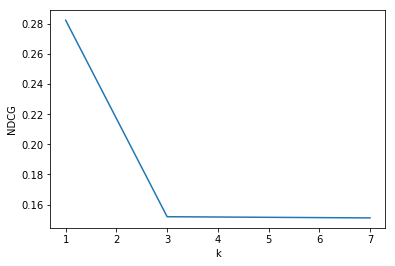

In [47]:
CV_name = 'CV_'
# evalutaion
CV_scores_3 = restruct(trec_eval(test_data, CV_name+'3.run'))
print(CV_name+'3.run')
print('Scores:', dict(zip(measure_names, CV_scores_3)))

CV_scores_7 = restruct(trec_eval(test_data, CV_name+'7.run'))
print('Scores:', dict(zip(measure_names, CV_scores_7)))

# print ndcg_cut_10 for k (number of clusters) 1,3,7 
# TODO: maybe use another measure ??
CV_scores = [AV_scores[0], CV_scores_3[0],CV_scores_7[0]]
plot_validation(CV_scores, [1,3,7])

### Task 4: Learning to rank (LTR) [15 points] (open-ended) ###

In this task you will get an introduction into learning to rank for information retrieval.

You can explore different ways for devising features for the model. Obviously, you can use the retrieval methods you implemented in Task 1, Task 2 and Task 3 as features. Think about other features you can use (e.g. query/document length). Creativity on devising new features and providing motivation for them will be taken into account when grading.

For every query, first create a document candidate set using the top-1000 documents using TF-IDF, and subsequently compute features given a query and a document. Note that the feature values of different retrieval methods are likely to be distributed differently.

You are adviced to start some pointwise learning to rank algorithm e.g. logistic regression, implemented in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
Train your LTR model using 10-fold cross validation on the test set. More advanced learning to rank algorithms will be appreciated when grading.

In [44]:
def ground_truth_parser(file_name):
    """
    parse ground truth and build dict
    
    query_id -> (document, score)
    
    where score is 1: relevant, 0: not relevant
    
    """
    F = open(file_name,"r")
    result= collections.defaultdict(list)
    last_query_id = None
    document_dict = collections.defaultdict(list)
    for row in F: 
        if len(row.strip()) == 0:
            continue
        row=row.split()
        doc_id = row[2]
        query_id = row[0]
        if query_id != last_query_id and not None:
            result[last_query_id] = document_dict
            document_dict = collections.defaultdict(list)
        try:
            doc_index = index.document_ids([doc_id])[0][1]
            document_dict[doc_index] = int(row[3])       
            last_query_id = row[0]
        except:
            print('document key error',row)
            None
    result[last_query_id] = document_dict
    return result


In [114]:
#Sentiment Analysis
from textblob import TextBlob
import nltk

def query_expansion(query_tokens):
    text = []
    for query_token in query_tokens:
        text.append(query_token)
        if query_token in word2vec_model.wv.vocab:
            for extracted_word in word2vec_model.wv.most_similar(query_token.lower()):
                text.append(extracted_word[0])
    return ' '.join(text)

def doc_sent(doc_id):
    text= ' '.join([id2token[word_id] for word_id in index.document(doc_id)[1] if word_id > 0])
    blob = TextBlob(text)
    polarity=0
    
    for sentence in blob.sentences:
        polarity+=sentence.sentiment.polarity
    
    return polarity

def query_sent(q_id):
    text=query_expansion(queries[q_id].split())
    blob = TextBlob(text)
    polarity=0
    
    for sentence in blob.sentences:
        polarity+=sentence.sentiment.polarity
    
    return polarity


In [115]:
def mean_cosine_similarity(query_id,document_id):
    query_terms=[]
    for term_id in tokenized_queries[query_id]:
        query_token = id2token[term_id] 
        if query_token in word2vec_model.wv.vocab:
            query_terms.append( query_token )
        
    vec_query = average_vec([word2vec_model.wv[word] for word in query_terms])
    document = index.document(document_id)
    terms_doc = [id2token[word_id] for word_id in document[1] if word_id > 0 and id2freq[word_id] > 5 ]
    vec_doc = average_vec([word2vec_model.wv[word] for word in terms_doc])
    return 1 - spatial.distance.cosine(vec_query, vec_doc)

def centroid_cosine_similarity(query_id,document_id):
    query_terms=[]
    for term_id in tokenized_queries[query_id]:
        query_token = id2token[term_id] 
        if query_token in word2vec_model.wv.vocab:
            query_terms.append( query_token )
        
    vec_query = [word2vec_model.wv[word] for word in query_terms]
    document = index.document(document_id)
    terms_doc = [id2token[word_id] for word_id in document[1] if word_id > 0 and id2freq[word_id] > 5 ]
    vec_doc = [word2vec_model.wv[word] for word in terms_doc]
    return centroid_similarity(vec_query,vec_doc, 8 )

print(mean_cosine_similarity("51",1),centroid_cosine_similarity('51',1))

-0.11738672726 -0.404663081566


In [116]:
def run_methods(query_id, int_document_id):
    #TODO add more features
    scores = []
    scores.append(tfidf(int_document_id, query_id, positional_inverted_index, None ))
    scores.append(BM25(int_document_id, query_id, positional_inverted_index , None ))
    scores.append(JM(int_document_id, query_id, positional_inverted_index , 0.1))
    scores.append(ADS(int_document_id, query_id, positional_inverted_index , 0.5))
    scores.append(DP(int_document_id, query_id, positional_inverted_index , 500))
    scores.append(mean_cosine_similarity(query_id,int_document_id)) # distance between the mean average vector of document and a query
    try:
        scores.append(centroid_cosine_similarity(query_id,int_document_id)) # distance between document's most important cluster and query 
    except:
        print("err",query_id, int_document_id)
        scores.append(0)
    scores.append((document_lengths[int_document_id]/len(tokenized_queries[query_id]))) # document length compared with query length 
    scores.append((unique_terms_per_document[int_document_id]/len(tokenized_queries[query_id]))) # unique word in document lengh compared with query length 
    scores.append(query_sent(query_id)) # sentiment polarity of query
    scores.append(doc_sent(int_document_id)) # sentiment polarity of document
    return scores

In [117]:
def get_features(ranked_queries):
    result = collections.defaultdict(list)
    for query_id, docs in ranked_queries.items():
        if query_id==None:
            continue
        dict_document = collections.defaultdict(list)
        for document_id in docs:
            dict_document[document_id] = run_methods(query_id,document_id)
        result[str(query_id)] = dict_document
    return result

In [118]:
index.document_ids(['AP901121-0246'])

()

In [119]:
# parse ground truth
ground_truth = ground_truth_parser('ap_88_89/qrel_test')
# obtain features from different ranking methods / other measures
features = get_features(ground_truth)

document key error ['149', '0', 'AP900109-0232', '0']
document key error ['149', '0', 'AP900214-0247', '0']
document key error ['149', '0', 'AP900215-0091', '0']
document key error ['149', '0', 'AP900327-0168', '1']
document key error ['149', '0', 'AP900427-0031', '1']
document key error ['149', '0', 'AP900429-0093', '0']
document key error ['149', '0', 'AP900607-0165', '0']
document key error ['149', '0', 'AP900904-0175', '0']
document key error ['149', '0', 'AP900913-0007', '0']
document key error ['149', '0', 'AP901121-0246', '0']
err 184 91412
err 152 30952
err 178 114626
err 166 105987
err 166 154627
err 166 86167
err 166 119294
err 166 119297
err 166 153612
err 166 86651
err 166 21521
err 166 42823
err 166 43880
err 166 18746
err 166 48982
err 166 15120
err 96 105987
err 96 153612
err 190 91412
err 121 114626


In [120]:
print( ground_truth.keys())

dict_keys([None, '68', '61', '101', '142', '176', '82', '106', '163', '199', '137', '153', '184', '146', '91', '186', '200', '149', '198', '131', '72', '171', '152', '183', '161', '81', '187', '97', '122', '169', '197', '66', '105', '80', '65', '177', '88', '160', '115', '83', '52', '70', '79', '141', '117', '124', '84', '178', '136', '172', '185', '134', '145', '76', '140', '166', '98', '128', '130', '85', '75', '60', '147', '107', '108', '133', '100', '139', '162', '189', '102', '118', '55', '51', '63', '96', '119', '129', '188', '125', '157', '164', '56', '174', '148', '154', '59', '138', '58', '194', '112', '126', '190', '99', '116', '121', '71', '54', '175', '168', '191', '110', '87', '64', '159', '193', '77', '62', '132', '179', '127', '67', '104', '156', '73', '195', '150', '196', '181', '109', '113'])


### Assumption:  For document-query pairs that do not exist in qrel file we assume that are irrelevant.

In [121]:
# fill Features and targets into arrays
X = []
Y = []

for query_id, docs in ground_truth.items():
    if query_id == None:
        continue
    for document_id in docs:
        # if document is in ifidf best 1000 ranking but not in ground truth discard it
        if ground_truth[query_id][document_id] is 0 or ground_truth[query_id][document_id] is 1:
            f=features[query_id][document_id]
            if len(f)!=0:
                Y.append(ground_truth[query_id][document_id])
                X.append(f)

In [122]:
print(X[:100],Y[:100])

[[5.4304953907708207, 3.5668920914354878, -50.420599981381606, -52.401726197291168, -51.367375317784365, 0.66059132898400807, 0.35150075197527086, 84.8, 59.2, 0.0, 0.01460243188184365], [14.289658802709233, 10.697715809333133, -46.30306008784202, -45.621086066260801, -45.54019136686469, 0.54234856299120193, 0.23295337392849391, 73.0, 49.0, 0.0, 0.13042790542790542], [24.872923763034379, 18.466353983270206, -42.309803027948874, -38.417563062998653, -39.71555876632172, 0.56879801719497736, 0.26572379905156107, 68.0, 43.8, 0.0, 0.08925603965926546], [0, 0, -51.321445523171938, -55.863941838323854, -52.998804204610082, -0.24026368322765301, -0.11080168910413302, 55.4, 40.2, 0.0, -0.030681818181818185], [0, 0, -51.321445523171938, -56.958565452705216, -52.638648563565674, 0.49550472507257215, 0.20755213767135872, 44.6, 26.0, 0.0, -0.004347826086956516], [14.065985852389934, 10.864748151824807, -45.698353726026994, -44.171414928295206, -44.309647124469052, 0.60735742178293084, 0.239243547723

In [123]:
from sklearn import linear_model, tree
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.preprocessing import StandardScaler

# split in test / train set for cross validation
X_train, X_test, y_train, y_test = train_test_split(X, Y)

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
# initialize logistic regression
logistic = linear_model.LogisticRegression(C=1e5)
logistic.fit(X,Y)
# perform 10 fold cross validation
scores = cross_val_score(logistic, np.asarray(X), np.asarray(Y), cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.74 (+/- 0.03)


In [ ]:
def predict_score(features):
    scores = collections.defaultdict(list)
    for query_id, document_ids in features.items():
        for document_id, feature in document_ids.items():
            ex_doc_id, _ = index.document(document_id)
            score = logistic.predict(np.asarray(feature).reshape(1,-1))[0]
            scores[str(query_id)].append((score,ex_doc_id))
    return scores


# parse ranked best 1000 docs per query ranked by tfidf
ranked_queries = query_doc_parser("tfidf.run")
# obtain features from different ranking methods / other measures
features = get_features(ranked_queries)
LR_scores = predict_score(features)
print(len(LR_scores['51']))
LR_name = 'LR'
# write scores to file
with open(LR_name+'.run', 'w') as f_out:
    write_run(
        model_name=LR_name,
        data=LR_scores,
        out_f=f_out,
        max_objects_per_query=1000)

In [240]:
# evalutaion
LR_scores = trec_eval(test_data, LR_name+'.run')
print('Scores:', dict(zip(measure_names, restruct(LR_scores))))
LR_scores = restruct(LR_scores,False)

Scores: {'ndcg_cut_10': 0.2451, 'map_cut_1000': 0.1165, 'P_5': 0.25, 'recall_1000': 0.6491}


In [263]:
# fill Features and targets into arrays
X = []
Y = []



def dataset_pairwise():
    
    pair_dataset= collections.defaultdict(list)
    for query_id, docs in ground_truth.items():
        if query_id is None:
            continue
        documents= collections.defaultdict(list)
        for document_id in docs:
            Y=[]
            # if document is in ifidf best 1000 ranking but not in ground truth discard it
            if ground_truth[query_id][document_id] is 0 or ground_truth[query_id][document_id] is 1:
                f=features[query_id][document_id]
                if len(f)!=0:
                    Y.append(ground_truth[query_id][document_id])
                    Y.append(f)
                    documents[int(document_id)]=Y
        pair_dataset[query_id]=documents
    
    
    return pair_dataset

data_pair = dataset_pairwise()
print(data_pair['51'])

defaultdict(<class 'list'>, {121638: [1, [17.801555270634744, 11.306617113711543, -15.307869415803065, -13.915152511112041, -14.495449173272171]], 100825: [1, [9.7877010191969802, 7.4002170657026802, -17.150519472341109, -15.664326534782411, -16.205978204127433]], 95275: [1, [14.499834897542762, 13.689481645868145, -14.361435798022281, -9.8778734773089951, -12.366453034544531]], 94324: [1, [33.300601757444845, 20.402533199502152, -11.170536804458838, -6.5897207119121592, -8.9004740966322178]], 117156: [1, [36.319223211288538, 20.440730039697662, -11.305863157575379, -6.7269106080377341, -8.5789211115897537]], 132373: [0, [4.7121338783457807, 4.6633186464033161, -18.411488858499439, -17.212441193361972, -17.597368189616667]], 136511: [1, [30.09757606125536, 20.052506194730821, -11.363054288834483, -6.7830547785539155, -9.3709316695725171]], 97513: [0, [5.7807738934780986, 6.0053156752964716, -17.498239367324572, -16.24161105647951, -16.658704891558038]], 161440: [1, [31.204280504129585,

In [323]:
def predict_score_pair(W1,b1,W2,b2,features):
    scores = collections.defaultdict(list)
    for query_id, document_ids in features.items():
        for document_id, feature in document_ids.items():
            ex_doc_id, _ = index.document(document_id)
            score = sigmoid(np.asarray(feature).dot(W1) + b1) 
            score = sigmoid(score.dot(W2) + b2) 
            scores[str(query_id)].append((score,ex_doc_id))
#             print(query_id,score,ex_doc_id,input_)
    return scores

def sigmoid (x,der=False):
    if der==True:
        return x * (1 - x)
    return 1/(1 + np.exp(-x))

def cross_entropy_loss(S_ij,s_i,s_j,der=False,sigma=0.5):
    if der==True:
        l_ij= sigma*(0.5*(1-S_ij)-(1/(1+(sigma*(s_i - s_j)))))
        return l_ij*(sigmoid(s_i,True)-sigmoid(s_j,True))
    
    return 0.5*(1 - S_ij)*(s_i - s_j)+(np.log(1+(sigma*(s_i - s_j))))
                                                        
#input
X=np.array([[1,1,1,1],[1,1,1,1],[0,0,0,0]])

#Output
T=np.array([[1],[1],[0]])


inputs=5
hidden_nodes=10
classes=1

# randomly initialize weights
W1 = np.random.randn(inputs, hidden_nodes)
b1 = np.random.randn(hidden_nodes)
W2 = np.random.randn(hidden_nodes, classes)
b2 = np.random.randn(classes)

hta = 10e-1
costs = []
for iterations in range(1000000):
    # forward pass
    # Randomly choose 2 documents and a query
    query_id = str(list(data_pair.keys())[np.random.randint(len(data_pair.keys()))])
    doc_i, doc_j = np.random.randint(len(data_pair[query_id].keys()), size=2)
    doc_i = list(data_pair[query_id].keys())[doc_i]
    doc_j = list(data_pair[query_id].keys())[doc_j]
    
    # get features for documents i and j
    x1 = np.asarray(data_pair[query_id][doc_i][1])
    x2 = np.asarray(data_pair[query_id][doc_j][1])
    
    
    
    # get a score for each document
    A = sigmoid(x1.dot(W1) + b1) 
    s_i = sigmoid(A.dot(W2) + b2) 
    
    B = sigmoid(x2.dot(W1) + b1)
    s_j = sigmoid(B.dot(W2) + b2) 
    
    # S ij ∈ {−1, 0, 1} indicate the preference between d i and d j .
    if data_pair[query_id][doc_i][0]>data_pair[query_id][doc_j][0]:
        S_ij=1
    elif data_pair[query_id][doc_i][0]==data_pair[query_id][doc_j][0]:
        S_ij=0
    else :
        S_ij=-1
    if S_ij!=0:
        
        # backward pass
        delta2 = cross_entropy_loss(S_ij,s_i,s_j,True) * sigmoid(s_i,True)
#         print(delta2.shape,W1.shape)
        delta1 = (delta2).dot(W2.T) * sigmoid(A,True)
        A=A.reshape(1,10)
        b=hta * A.T.dot(delta2)
        W2 -= b.reshape(10,1)
#       print(W2.shape)
        b2 -= hta * (delta2).sum(axis=0)
        
        delta1=delta1.reshape(1,10)
#       print(delta1.shape)
        x=x.reshape(1,inputs)
        W1 -= hta * x.T.dot(delta1)
        b1 -= hta * (delta1).sum(axis=0)
#   print(data_pair[query_id][doc_i][0],data_pair[query_id][doc_j][0],cross_entropy_loss(S_ij,s_i,s_j,True))
    # save loss function values across training iterations
        loss+=cross_entropy_loss(S_ij,s_i,s_j)
        if (iterations+1) % 1000 == 0:
        
#         print('Loss function value: ', loss)
            features = get_features(ranked_queries)
            lambdarak_scores=predict_score_pair(W1,b1,W2,b2,features)
            costs.append((iterations,loss))
            lambdarank = 'lambdarank'
            # write scores to file
            loss=0
            with open(lambdarank+str(iterations)+'.run', 'w') as f_out:
                write_run(model_name=lambdarank,data=lambdarak_scores,out_f=f_out,max_objects_per_query=1000)
            lambdarank_scores = trec_eval(test_data, lambdarank+str(iterations)+'.run')
            print('Scores:', dict(zip(measure_names, restruct(lambdarank_scores))))

Scores: {'ndcg_cut_10': 0.0529, 'map_cut_1000': 0.049, 'P_5': 0.0617, 'recall_1000': 0.6491}


KeyboardInterrupt: 

### Task 4: Write a report [15 points; instant FAIL if not provided] ###

The report should be a PDF file created using the [sigconf ACM template](https://www.acm.org/publications/proceedings-template) and will determine a significant part of your grade.

   * It should explain what you have implemented, motivate your experiments and detail what you expect to learn from them. **[10 points]**
   * Lastly, provide a convincing analysis of your results and conclude the report accordingly. **[10 points]**
      * Do all methods perform similarly on all queries? Why?
      * Is there a single retrieval model that outperforms all other retrieval models (i.e., silver bullet)?
      * ...

**Hand in the report and your self-contained implementation source files.** Only send us the files that matter, organized in a well-documented zip/tgz file with clear instructions on how to reproduce your results. That is, we want to be able to regenerate all your results with minimal effort. You can assume that the index and ground-truth information is present in the same file structure as the one we have provided.

